In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing.image import ImageDataGenerator

In [2]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = (224, 224, 1), activation = 'relu'))

classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Flatten())

classifier.add(Dense(units = 128, activation = 'relu'))

classifier.add(Dense(32))

classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory("C:\\Users\\Kavya Duvvuri\\ICS End Sem\\Grayscale Dataset\\Training", target_size = (224, 224), batch_size = 50, class_mode = 'binary', color_mode = 'grayscale')

test_set = test_datagen.flow_from_directory("C:\\Users\\Kavya Duvvuri\\ICS End Sem\\Grayscale Dataset\\Validation", target_size = (224, 224), batch_size = 50, class_mode = 'binary', color_mode = 'grayscale')

Found 2931 images belonging to 2 classes.
Found 731 images belonging to 2 classes.


In [4]:
classifier.fit(training_set, steps_per_epoch = 5, epochs = 30, validation_data = test_set)

Epoch 1/30
5/5 [==============================] - 8s 2s/step - loss: 4.5701 - accuracy: 0.4960 - val_loss: 6.0156 - val_accuracy: 0.5499
Epoch 2/30
5/5 [==============================] - 11s 2s/step - loss: 2.7089 - accuracy: 0.7160 - val_loss: 1.5422 - val_accuracy: 0.5923
Epoch 3/30
5/5 [==============================] - 8s 2s/step - loss: 0.8503 - accuracy: 0.7400 - val_loss: 0.3721 - val_accuracy: 0.8591
Epoch 4/30
5/5 [==============================] - 8s 2s/step - loss: 0.4920 - accuracy: 0.8800 - val_loss: 0.5571 - val_accuracy: 0.8728
Epoch 5/30
5/5 [==============================] - 9s 2s/step - loss: 0.5791 - accuracy: 0.8520 - val_loss: 0.3391 - val_accuracy: 0.8700
Epoch 6/30
5/5 [==============================] - 8s 2s/step - loss: 0.4031 - accuracy: 0.8320 - val_loss: 0.2389 - val_accuracy: 0.8906
Epoch 7/30
5/5 [==============================] - 8s 2s/step - loss: 0.3029 - accuracy: 0.8880 - val_loss: 0.2237 - val_accuracy: 0.8988
Epoch 8/30
5/5 [========================

In [5]:
import cv2
import os
import numpy as np
from keras.preprocessing import image
import tensorflow as tf

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        images.append(os.path.join(folder, filename))
    return images

In [6]:
images = load_images_from_folder("C:\\Users\\Kavya Duvvuri\\ICS End Sem\\Grayscale Dataset\\Validation\\Positive")

predictions = []
for im in images: 
    test_image = image.load_img(im, target_size = (224, 224))
    test_image = tf.image.rgb_to_grayscale(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = classifier.predict(test_image)
    i = np.argmax(result[0])
    training_set.class_indices
    
    if result[0][0] <= 0.5:
        prediction = 'Negative'
    else: 
        prediction = 'Positive'
    predictions.append(prediction)
print(predictions.count('Positive'))
print(predictions.count('Negative'))

310
61


In [7]:
images = load_images_from_folder("C:\\Users\\Kavya Duvvuri\\ICS End Sem\\Grayscale Dataset\\Validation\\Negative")

predictions = []
for im in images: 
    test_image = image.load_img(im, target_size = (224, 224))
    test_image = tf.image.rgb_to_grayscale(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = classifier.predict(test_image)
    i = np.argmax(result[0])
    training_set.class_indices
    
    if result[0][0] <= 0.5:
        prediction = 'Negative'
    else: 
        prediction = 'Positive'
    predictions.append(prediction)
print(predictions.count('Positive'))
print(predictions.count('Negative'))

8
352


In [9]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt 

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        
        for layer in reversed(self.model.layers):
           
            if len(layer.output_shape) == 4:
                return layer.name
        
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        
        with tf.GradientTape() as tape:
            
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        
        grads = tape.gradient(loss, convOutputs)

        
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
       
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # error here...
        
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
       
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap = cv2.COLORMAP_TWILIGHT):
        print("Overlay_heatmap")
        print("Image")
        print(image.shape)
        print("Heatmap")
        print(heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap, colormap)
        print("Heatmap")
        #heatmap = cv2.resize(heatmap, (224, 224, 1), interpolation = cv2.INTER_AREA)
        print(heatmap.shape)
        heatmap = np.expand_dims(heatmap, axis = 0)
        print("Heatmap")
        print(heatmap.shape)
        #output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        
        return heatmap

(224, 224, 3)
(224, 224, 1)


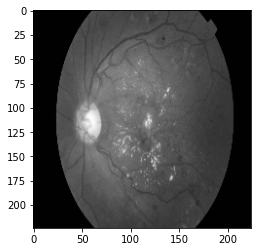

(224, 224)


In [19]:
image = cv2.imread('C:\\Users\\Kavya Duvvuri\\ICS End Sem\\Grayscale Dataset\\Training\\Yes3.png')
print(image.shape)
image = tf.image.rgb_to_grayscale(image)

#image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
print(image.shape)

image = np.squeeze(image)
plt.imshow(image, cmap = 'gray')
plt.show()
print(image.shape)
image1 = image
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = classifier.predict(image) 
i = np.argmax(preds[0])

In [20]:
icam = GradCAM(classifier, i) 

heatmap = icam.compute_heatmap(image)
print("Heatmap")
print(heatmap.shape)
print("Image")
print(image1.shape)
image1 = np.expand_dims(image1, axis = 0)
print("Image")
print(image1.shape)
heatmap = icam.overlay_heatmap(heatmap, image1, alpha = 0.5)

Heatmap
(224, 224)
Image
(224, 224)
Image
(1, 224, 224)
Overlay_heatmap
Image
(1, 224, 224)
Heatmap
(224, 224)
Heatmap
(224, 224, 3)
Heatmap
(1, 224, 224, 3)


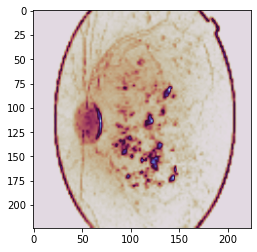

In [21]:
plt.imshow(heatmap[0])
plt.show()